In [1]:
from scipy import sparse
from scipy.sparse import linalg
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

%matplotlib inline

np.set_printoptions(linewidth=150)


In [2]:
I = t.eye(10, device='cpu', dtype=t.float64)

N = 10
m = 2

idxs = t.empty((3, m * N))
idxs[0] = t.hstack([t.ones(N) * i for i in range(m)])
idxs[1] = t.arange(0, N).tile((m))
idxs[2] = t.arange(0, N).tile((m))

# idxs = t.arange(0, N).tile((2, 1))
v = t.ones(N).tile(m)
Isp = t.sparse_coo_tensor(idxs, v, (m, N, N))
Isp.to_dense()

# # Isp

NameError: name 't' is not defined

In [3]:
np.kron(np.ones((2, 2)), np.eye(2))



array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.]])

In [4]:
np.kron(np.eye(2), np.ones((2, 2)))

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.]])

In [67]:
L = 10
M = 2

diag1 = np.ones(L - 2)
DT1 = sparse.spdiags([diag1, -2*diag1, diag1], [0, -1, -2], L, L - 2)  # transposed D
H1 =  DT1.dot(DT1.T) 

diag2 = np.ones(M - 2)
DT2 = sparse.spdiags([diag2, -2*diag2, diag2], [0, -1, -2], M, M - 2)  # transposed D
H2 =  DT2.dot(DT2.T)  

Hkron1 = np.kron(np.eye(M), H1.toarray())
Hkron2 = np.kron(H2.toarray(), np.eye(L))

print(Hkron1, '\n')
print(Hkron2, '\n')

print(Hkron1 + Hkron2)

[[ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  5. -4.  1.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  6. -4.  1.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  6. -4.  1.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  6. -4.  1.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -4.  6. -4.  1.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -4.  6. -4.  1.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -4.  6. -4.  1.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -4.  5. -2.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.]
 [ 0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -2.  5. -4.  1.  0.  0.  0.  0.  0.  0.]
 [ 0

In [2]:
# based on https://pubs.rsc.org/en/content/articlelanding/2015/AN/C4AN01061B#!divAbstract
# form https://stackoverflow.com/questions/29156532/python-baseline-correction-library
def baseline_arPLS(y, ratio=1e-6, lam=100, niter=10):
    L = len(y)

    diag = np.ones(L - 2)
    DT = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)  # transposed D

    H = lam * DT.dot(DT.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252

    w = np.ones(L)
    W = sparse.eye(L)

    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    return z, d

def baseline_arPLS_MAT(Y, ratio=1e-6, lam=100, niter=10):
    L = Y.shape[0]
    M = Y.shape[1]

    diag = np.ones(L - 2)
    DT = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)  # transposed D

    H = lam * DT.dot(DT.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252
    
    Hkron = sparse.kron(sparse.eye(M), H)
    y = Y.reshape((L * M,))

    w = np.ones(L * M)
    W = sparse.eye(L * M)

    crit = 1
    count = 0

    while crit > ratio:
        wkr = W + Hkron
        print(wkr.toarray())
        print((w * y).shape)
        print(w * y)
        z = linalg.spsolve(wkr, w * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    return z.reshape((L, M)), d.reshape((L, M))

# from https://stackoverflow.com/questions/40104377/issiue-with-implementation-of-2d-discrete-cosine-transform-in-python
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def baseline_2D_arPLS(Y, lam0=1e5, lam1=1e2, niter=10):
    N = Y.shape[0]
    K = Y.shape[1]
    
    W = np.ones_like(Y)  # weight matrix

    l0 = lam0 * (-2 + 2 * np.cos(np.arange(N) * np.pi / N)) ** 2
    l1 = lam1 * (-2 + 2 * np.cos(np.arange(K) * np.pi / K)) ** 2
    
    basis = l0[:, None] + l1[None, :]

    for i in range(niter):
        gamma = W + basis
        
        Z = idct2(dct2(W * Y) / gamma)  # baseline
        
        D = Y - Z  # data corrected for baseline
        Df = D.flatten()
        
        Dfn = Df[Df < 0]

        m = np.mean(Dfn)
        s = np.std(Dfn)

        W = 1 / (1 + np.exp(2 * (D - (2 * s - m)) / s))
        
    return Z, D



#  from 10.1016/j.csda.2009.09.020
def smooth2D(Y, lam0=1e5, lam1=1e2):
    N = Y.shape[0]
    K = Y.shape[1]

    l0 = 1 + lam0 * (-2 + 2 * np.cos(np.arange(N) * np.pi / N)) ** 2
    l1 = 1 + lam1 * (-2 + 2 * np.cos(np.arange(K) * np.pi / K)) ** 2

    basis = l0[:, None] * l1[None, :]

    smooth = idct2(dct2(Y) / basis)
    return smooth


def baseline_batch_arPLS(Y, ratio=1e-6, lam=1e4, niter=10):
    assert Y.ndim == 2
    L = Y.shape[0]  # first dimension, iteration will go though second dimension

    diag = np.ones(L - 2)
    DT = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)  # transposed D

    H = lam * DT.dot(DT.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252

    weights = np.ones_like(Y)
    
    W = [sparse.eye(L) for i in range(Y.shape[1])]
    
    Z = np.empty_like(Y)  # baseline
    D = np.empty_like(Y)  # pure signal

    crit = 1
    count = 0
    
    while crit > ratio:
        for i in range(Y.shape[1]):
            Z[:, i] = linalg.spsolve(W[i] + H, W[i] * Y[:, i])
            
        D = Y - Z
        Dn = D.copy()
        Dn[Dn >= 0] = np.nan

        m = np.nanmean(Dn, axis=0, keepdims=True)
        s = np.nanstd(Dn, axis=0, keepdims=True)

        w_new = 1 / (1 + np.exp(2 * (D - (2*s - m))/s))  # logistic function

        crit = norm(w_new - weights) / norm(weights)

        weights = w_new
        
        for i in range(Y.shape[1]):
            W[i].setdiag(weights[:, i])
        
        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    return Z, D


    
def baseline_naive(y, lam=1e4):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)
    
    I = sparse.eye(L)
    z = linalg.spsolve(I + H, y)
    
    return z, y - z

def baseline_AsLS(y, lam=1e4, p=0.1, niter=10):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)
    
    W = sparse.eye(L)
    
    for i in range(niter):
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        
        w = np.where(d > 0, p, 1-p)

        W.setdiag(w)

    return z, d
    
def spectra_model(x):
    coeff = np.array([100, 200, 100, 50])
    mean = np.array([300, 750, 800, 450])

    stdv = np.array([30, 30, 15, 30])

    terms = []
    for ind in range(len(coeff)):
        term = coeff[ind] * np.exp(-((x - mean[ind]) / stdv[ind])**2)
        terms.append(term)

    spectra = sum(terms)

    return spectra

x_vals = np.arange(1, 1001)
spectra_sim = spectra_model(x_vals)

In [3]:
from scipy.interpolate import CubicSpline
x_poly = np.array([0, 250, 700, 1000])
y_poly = np.array([200, 180, 230, 200])

poly = CubicSpline(x_poly, y_poly)
baseline = poly(x_vals)

spectra_base = np.random.normal(spectra_sim + baseline + 100,  5.5)  # add a noise

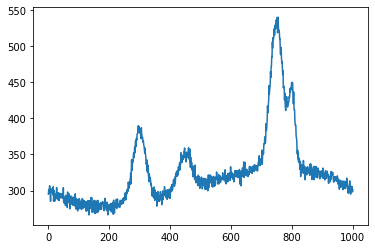

In [4]:
plt.plot(x_vals, spectra_base)
plt.show()

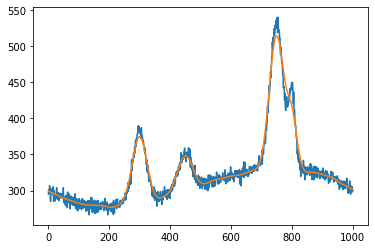

In [5]:
# def dct2(block):
#     return dct(dct(block.T, norm='ortho').T, norm='ortho')

# def idct2(block):
#     return idct(idct(block.T, norm='ortho').T, norm='ortho')

# N = spectra_base.shape[0]
# lam0 = 1e5
# l0 = 1 + lam0 * (-2 + 2 * np.cos(np.arange(N) * np.pi / N)) ** 2
# gamma = 1 / l0

# smooth = idct(gamma * dct(spectra_base))
Z, smooth = baseline_naive(spectra_base, lam=1e4)

plt.plot(x_vals, spectra_base)
plt.plot(x_vals, Z)
plt.show()

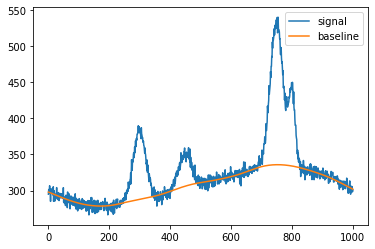

In [7]:
Z, D = baseline_batch_arPLS(spectra_base[:, None], lam=1e6, niter=20)
# Z, D = baseline_arPLS(spectra_base, lam=1e4, niter=50)

plt.plot(x_vals, spectra_base, label='signal')
plt.plot(x_vals, Z, label='baseline')
plt.legend()
plt.show()

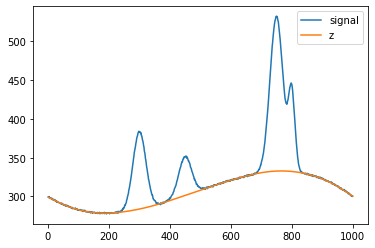

In [14]:
plt.plot(x_vals, spectra_base, label='signal')
plt.plot(x_vals, Z, label='z')
plt.legend()
plt.show()

In [130]:
data = np.genfromtxt('UV_2Z irr, photoproducts2.csv', encoding='utf8', filling_values=0, delimiter=',')

times, wls, matrix = data[1:, 0], data[0, 1:], data[1:, 1:]
data_sel = matrix[500:-700, :]
times_s = times[500:-700]
data_sel.shape

(3300, 760)

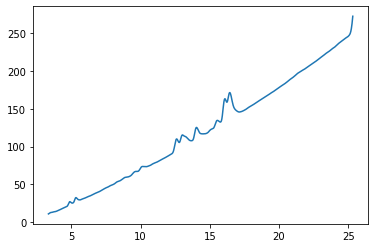

In [16]:
trace = data_sel[:, 10]
plt.plot(times_s, trace)
plt.show()

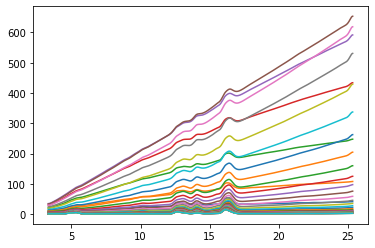

In [163]:
_d = data_sel[:, :50]

N = _d.shape[0]
K = _d.shape[1]
lam0 = 1e5
lam1 = 1

l0 = 1 + lam0 * (-2 + 2 * np.cos(np.arange(N) * np.pi / N)) ** 2
l1 = 1 + lam1 * (-2 + 2 * np.cos(np.arange(K) * np.pi / K)) ** 2

gamma = l0[:, None] * l1[None, :]

smooth = idct2(dct2(_d) / gamma)

plt.plot(times_s, smooth)
plt.show()




# Z, D = baseline_batch_arPLS(_d, lam=1e6, niter=0)
# Z_, D_ = baseline_arPLS_MAT(_d, lam=1e6, niter=0)

# plt.plot(times_s, _d, color='red')
# plt.plot(times_s, Z, color='black')

# plt.show()

# plt.plot(times_s, _d, color='red')
# plt.plot(times_s, Z_, color='black')
# plt.show()


In [85]:
np.allclose(Z, Z_)
Z_

array([[ 5.64217736,  5.65478409],
       [ 5.66738968,  5.67999461],
       [ 5.69259839,  5.70520184],
       ...,
       [62.24675591, 62.29152079],
       [62.33632166, 62.38115509],
       [62.42600484, 62.47086891]])